In [1]:
# 1.) Generate sequence of length k using Student model
# 2.) Evaluate drafted sequence using Teacher model
# 3.) Evaluate drafted sequence using Student model
# 4.) Calculate loss
# 5.) Backprop

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.utils import logging
import matplotlib.pyplot as plt
from datasets import load_dataset

logging.set_verbosity_error()

import torch
from torch.utils.data import DataLoader

In [3]:
# student_model_id = "Qwen/Qwen3-0.6B"
# teacher_model_id = "Qwen/Qwen3-1.7B"
student_model_id = "Qwen/Qwen2.5-0.5B-Instruct"
teacher_model_id = "Qwen/Qwen2.5-1.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(student_model_id)
pad_token_id = tokenizer.pad_token_id
eos_token_id = tokenizer.eos_token_id

student = AutoModelForCausalLM.from_pretrained(
    student_model_id,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.float16,
    device_map="cuda:1",
)
student.config.pad_token_id = pad_token_id
student.config.eos_token_id = eos_token_id

teacher = AutoModelForCausalLM.from_pretrained(
    teacher_model_id,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.float16,
    device_map="cuda:1",
).eval()
teacher.config.pad_token_id = pad_token_id
teacher.config.eos_token_id = eos_token_id

In [4]:
ds = load_dataset("abisee/cnn_dailymail", "3.0.0", split="train[:1%]")

In [5]:
# ================
# Need to find a way to tokenize text that preserves the attention mask while also
# making a clear END to the user input. Currently, the models are just completing
# whatever the input text was if the tokenizer truncates.
# ================
def tokenize_function(examples, tokenizer, max_length):
    prompt = [
        {"role": "system", "content": "You are a concise, factual assistant."},
        {
            "role": "user",
            "content": f"Summarize this in 1 sentence {examples['article']}",
        },
    ]

    end_marker = "\n\nSummary:"
    end_ids = tokenizer(end_marker, add_special_tokens=False)["input_ids"]

    tokenized_prompt = tokenizer.apply_chat_template(
        prompt,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        enable_thinking=False,
        padding="max_length",
        truncation=True,
        max_length=max_length - len(end_ids),
        return_tensors=None,
    )

    return {
        "input_ids": tokenized_prompt["input_ids"] + end_ids,
        # "attention_mask": tokenized_prompt["attention_mask"],
    }


tokenized_dataset = ds.map(
    tokenize_function,
    fn_kwargs={"tokenizer": tokenizer, "max_length": 256},
    batched=False,
    remove_columns=ds.column_names,
)

# 2) Tell datasets to return torch tensors on indexing
tokenized_dataset = tokenized_dataset.with_format(
    type="torch",
    columns=["input_ids"],
)

In [6]:
# Will use this for training loop
dl = DataLoader(tokenized_dataset, batch_size=1, shuffle=True, drop_last=True)

In [54]:
# 1. Generate sequence with length k from Student model
k = 64

# Sample per iteration
# torch.distributions.uniform.Uniform(0.75, 1.25).sample()

for batch in dl:
    with torch.no_grad():
        outputs = student.generate(
            input_ids=batch["input_ids"].to(student.device),
            # attention_mask=batch["attention_mask"].to(student.device),
            max_new_tokens=k,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )
    break

In [55]:
# print(tokenizer.decode(outputs[0][: batch["input_ids"].shape[1]]))
print(tokenizer.decode(outputs[0][batch["input_ids"].shape[1] :]))

 Scientists have warned that the massive Wilkins ice shelf in Antarctica could collapse soon due to global warming, threatening to break off from the continent.<|im_end|>


In [56]:
# 2.) Evaluate drafted sequence using Teacher model
# Use up to k-1, teacher and student will predict next token (we already have the label)
student_draft = outputs[:, :-1]
with torch.no_grad():
    logits_t = teacher(student_draft).logits
    logits_t = logits_t[:, batch["input_ids"].shape[1] :, :]

In [57]:
# 3.) Evaluate drafted sequence using Student model
logits_s = student(student_draft).logits
logits_s = logits_s[:, batch["input_ids"].shape[1] :, :]

In [58]:
# 4.) Calculate loss
T = 1.0
logp_s = torch.log_softmax(logits_s / T, dim=-1)
p_t = torch.softmax(logits_t / T, dim=-1)
kd_tok = torch.nn.functional.kl_div(logp_s, p_t, reduction="none") * (T * T)
kd_seq = kd_tok.sum(dim=-1)
loss = kd_seq.mean()

In [59]:
# 5.) Backprop
loss.backward()

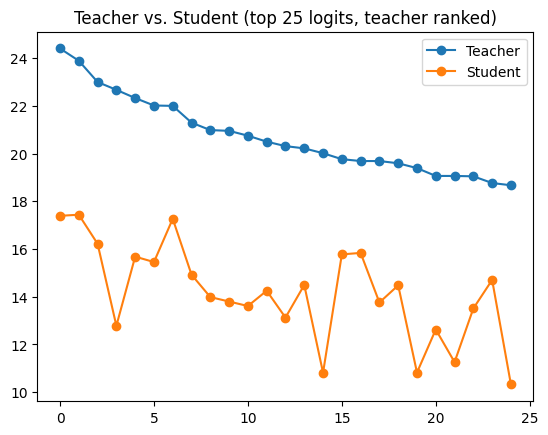

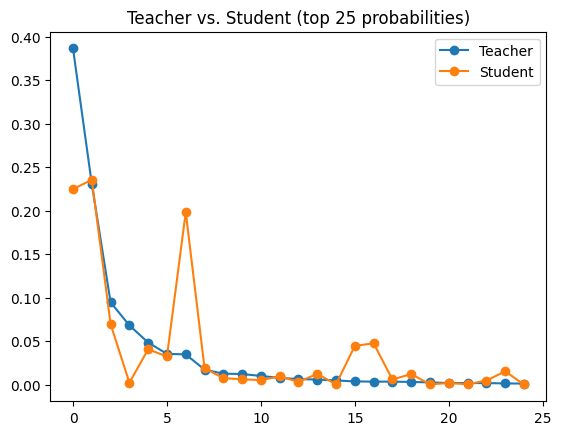

In [72]:
N = 25
topN_t, topN_idx = torch.topk(logits_t.cpu(), N)
topN_s = torch.gather(logits_s.detach().cpu(), dim=2, index=topN_idx)

plt.title(f"Teacher vs. Student (top {N} logits, teacher ranked)")
plt.plot(topN_t[0, 0, :], "-o", label="Teacher")
plt.plot(topN_s[0, 0, :], "-o", label="Student")
plt.legend()
plt.show()

plt.title(f"Teacher vs. Student (top {N} probabilities)")
plt.plot(torch.softmax(topN_t[0, 0, :], dim=-1), "-o", label="Teacher")
plt.plot(torch.softmax(topN_s[0, 0, :], dim=-1), "-o", label="Student")
plt.legend()
plt.show()

In [61]:
logits_t.shape

torch.Size([1, 28, 151936])

In [64]:
print("Draft sequence")
print(tokenizer.decode(outputs[0][batch["input_ids"].shape[1] :]))

Draft sequence
 Scientists have warned that the massive Wilkins ice shelf in Antarctica could collapse soon due to global warming, threatening to break off from the continent.<|im_end|>


In [66]:
print("Student Output (greedy decoding)")
print(tokenizer.decode(logits_s.argmax(dim=-1)[0]))

Student Output (greedy decoding)
 have warned that the Antarctic Wilkins ice shelf in Antarctica is collapse within, to global warming, threatening to dis off and the ice.<|im_end|>


In [67]:
print("Teacher Output (greedy decoding)")
print(tokenizer.decode(logits_t.argmax(dim=-1)[0]))

Teacher Output (greedy decoding)
 warn warned that a Wil Wilkins ice shelf in Antarctica is collapse,, to global warming, with sea dis off an the continent and<|im_end|>
